# AIPI 590 - XAI | Assignment #3
### Explainable Techniques II
### Anish Parmar

### Majority of the code was taken from the class Github notebooks and the explanations were self-formulated. AI was not used in this assignment. 


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anishParmar9778/DukeXAI/blob/main/HW3/AIPI_590_explainable_techniques_2.ipynb)

## **Model & Dataset Setup**

**Dataset**

I used the Pima Indians Diabetes Dataset (I was provided with this dataset in my Data Science class - COMPSCI 526). This is a classification task to predict if people have diabetes or not.

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

**Model**

I trained an XGBoost classifier model with default parameters for explanatory purposes. I am also performing a 80-20 train/test split.

In [1]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-uktfjni_/alepython_ad3febb28b614d5e96db9015b4917295
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-uktfjni_/alepython_ad3febb28b614d5e96db9015b4917295
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350ab6-py3-none-any.whl size=15251 sha256=6a5e203f56047151024e113ad58b0bad03f454e8c72bba06858d67665b79b02a
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_m9xt6n/wheels/87/54/8b/9357059e0e9ade0ea889a30fe56beaed44312e07475133b2cc
Successfully built alepython


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost
from sklearn.model_selection import train_test_split

import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns

In [3]:
df = pd.read_csv("diabetes.csv")

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

In [5]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7207792207792207

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.77        99
           1       0.59      0.71      0.64        55

    accuracy                           0.72       154
   macro avg       0.70      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154



In [6]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", feature_importance)


Feature Importances:
 Glucose                     0.250108
Age                         0.137263
BMI                         0.136059
SkinThickness               0.109254
Insulin                     0.104099
BloodPressure               0.091153
DiabetesPedigreeFunction    0.088837
Pregnancies                 0.083229
dtype: float32


In [7]:
corr_with_outcome = df.corr()['Outcome'].sort_values(ascending=False)
print(corr_with_outcome)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


From the results above, we can see that **Glucose**, **BMI**, and **Age** appear to be the top 3 features that are correlated with a positive diabetes outcome.

Below we will investigate what further information we can learn from these 3 features via PLP, ALE, and ICE plots.

Since these are the 3 strongest predictors, I think it made the most sense to focus on these features in particular.

In [8]:
corr_matrix = df.corr()

print("\nFull Feature-to-Feature Correlation Matrix:\n", corr_matrix)


Full Feature-to-Feature Correlation Matrix:
                           Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.03352

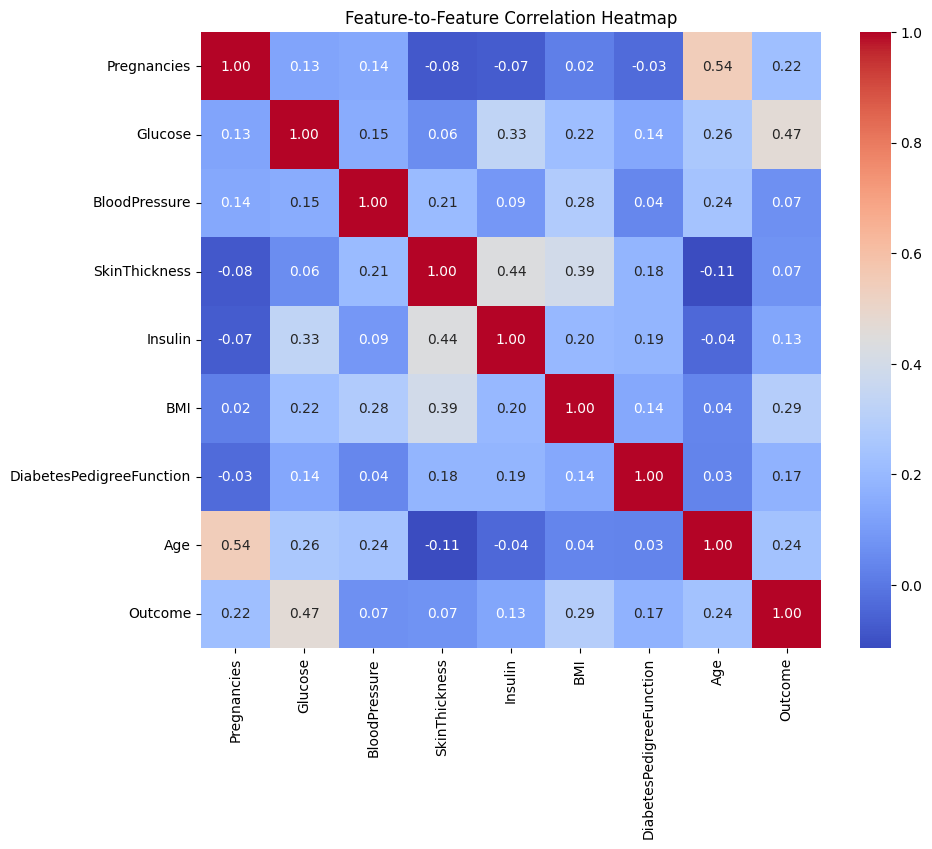

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Feature-to-Feature Correlation Heatmap")
plt.show()

To further explore the relationships between all the features in the dataset, I computed the entire feature-to-feature correlation matrix and heatmap above.

There appears to be a strong positive correlation between Pregnancies and Age (0.54). There are moderate correlations between BMI, SkinThickness, and Insulin (BMI with SkinThickness at 0.39 and SkinThickness with Insulin at 0.44). Glucose also shows moderate correlation but with Insulin (0.33) and Age (0.26). Most of the other feature pairings have weak correlations (close to zero) and likely provide distinct information.

Just as we saw earlier with the feature importance tests, Glucose (0.47), BMI (0.29), and Age (0.24) had the strongest positive correlation with a positive diabetes outcome. Glucose is clearly the most predictive factor while BMI and Age are still influential but slightly weaker.

##**PDP Plots**

The code in this section was taken from the global_explanations.ipynb from the class Github.

https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

**Glucose PLP Plot**

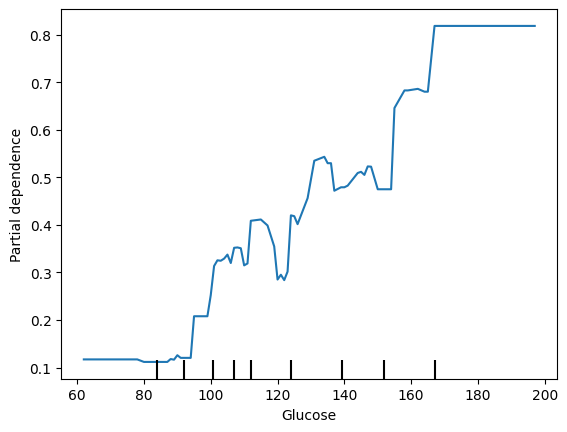

In [10]:
# Choose the feature of interest
features = ["Glucose"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both'

**Explanation**

The curve is clearly non-linear and does not show a smooth, gradual relationship. It appears to be more like a piecewise constant or step-like function. The partial dependence stays constant over multiple glucose ranges and then jumps up significantly at certain thresholds.

It appears that generally increasing the glucose value leads to a higher partial dependence (higher average predicted probability of a patient having diabetes). The curve stays pretty flat and low from 60 to 95. From 95 to 160, the curve trends upward with jumps at around 100, 115, 125, 145, and a very high jump around 155. This suggests that the probability of a positive diabetes prediction substantially increases as glucose values get near or above this range.

The lower limit/plateau appears to be at around 0.1 to 0.15 for glucose values in between 60 and 95. This implies that patients who have glucose levels within this range have a consistently low positive diabetes prediction probability. Further decreases in glucose below 95 don't seem to have a significant impact on the model's predictions.

The upper limit/plateau appears to be around 0.85 to 0.9 for glucose values above 160. This implies that patients with a glucose value around 160 have a high predicted probability for positive diabetes. Further increases in glucose beyond that range would have minimal impact on the model's predictions.

This relationship observed in the plot makes sense since it is common knowledge in the medicine world that glucose is the most integral feature with diagnosing diabetes. Low glucose levels suggest a low probability of diabetes and high glucose levels suggest a high probability of diabetes.

**BMI PLP Plot**

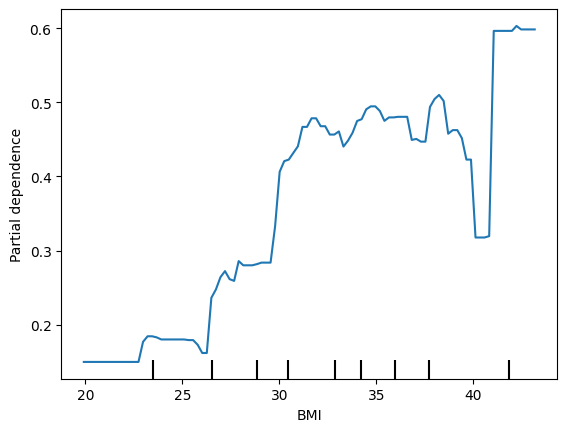

In [11]:
# Choose the feature of interest
features = ["BMI"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both'

**Explanation**

Just like Glucose, the curve is non-linear and appears to be more like that of a step-like function.

Generally, increasing Body Mass Index (BMI) leads to a higher partial dependence which indicates a higher predicted probability of diabetes (from a value of 26 onwards).

The plot's low plateau is around 0.17 for BMI values below 26, implying further decreases in BMI have little impact on the low predicted risk. It reaches a high plateau around 0.53-0.54 for BMI values above 40.

Just like glucose, these results make sense since high BMI is a major, well-established risk factor for Type 2 diabetes. The rapid increase in predicted risk starting around BMI values of 26 is consistent with the transition from a healthy to an overweight or obese category where diabetes risk rapidly increases.

**Age PLP Plot**

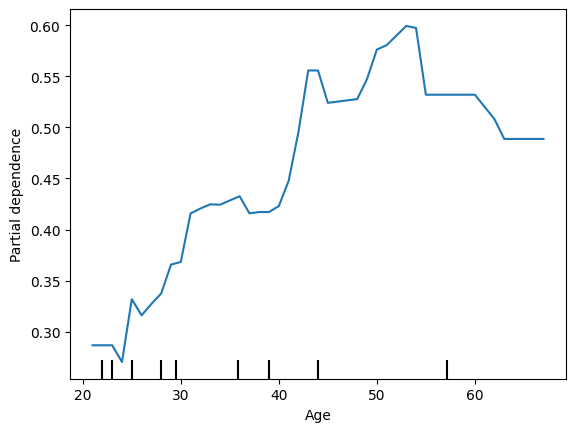

In [12]:
# Choose the feature of interest
features = ["Age"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both'

**Explanation**

Here the curve is again non-linear but instead has a more wavy, step-like pattern. This shape suggests that the influence of age on the predicted diabetes probability is more complex than that of BMI and Glucose, with changes occurring at several distinct age thresholds.

Generally, increasing age leads to a higher partial dependence, implying that older age groups have a higher predicted probability of diabetes up to a certain point. The plot shows a strong upward trend from around age 25 to 50.

The low plateau appears to be for the youngest individuals (ages 20 to 25) where the dependence is around 0.25 to 0.27. The curve seems to hit a high plateau (around 0.47) for ages approximately 65 and older, suggesting that the risk stabilizes for the oldest group.

The results are again expected because the dramatic increase in risk during middle ages (25 to 50) accurately reflects the typical onset period for this condition. The late high plateau in the later ages suggests the influence of age weakens compared to other factors in the very elderly.

## **ALE Plots**

The code in this section was taken from the global_explanations.ipynb from the class Github.

https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

**Glucose ALE Plot**

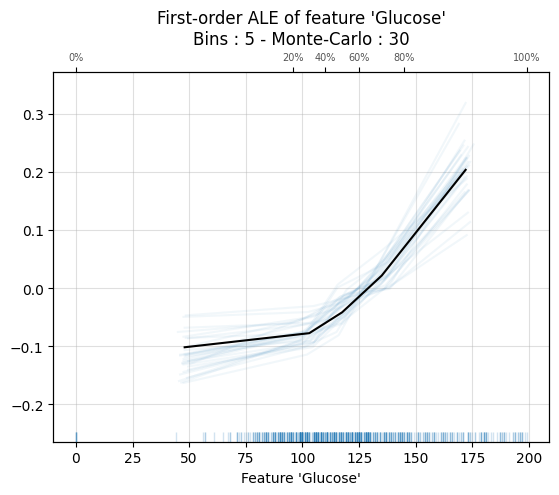

<Axes: title={'center': "First-order ALE of feature 'Glucose'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Glucose'">

In [15]:
ale_plot(
    model,
    X_train,
    "Glucose",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

**Explanation**

 The ALE plot is much smoother than the PDP plot for glucose. Below somewhere near 126, Glucose has a negative accumulated effect (decreasing the predicted risk of diabetes below the average). However it quickly changes to a strongly positive effect for values above this point (increasing the predicted risk). This transition point highlights the Glucose level where the model's prediction changes from reducing the diabetes risk to increasing it. This threshold is also in alignment with clinical thresholds for pre-diabetes and diabetes.

The ALE plot is a more reliable and unbiased representation of the marginal effect of Glucose. Unlike PDP plots, it is not distorted by unrealistic feature combinations (correlations) in the data. The PDP displayed a piecewise, step-like function showing the probability always increasing in steps. In contrast, the ALE plot is a smooth curve that defines a critical zone between 110 and 140 where glucose's influence on the prediction changes most drastically. I think this smoothness and isolation of the local effect make the ALE plot better for interpreting the true, non-linear relationship learned by the model for a feature like glucose.

**BMI ALE Plot**

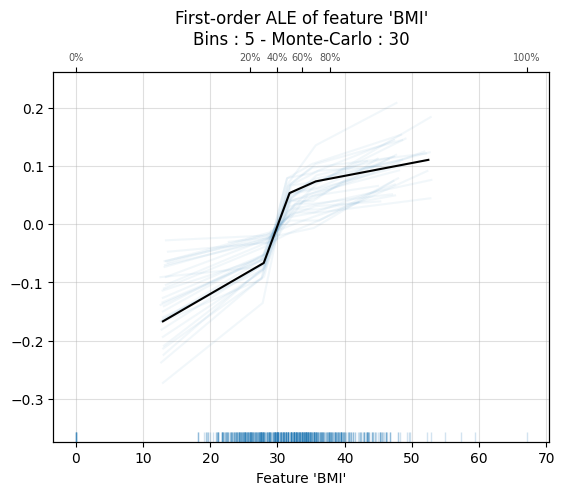

<Axes: title={'center': "First-order ALE of feature 'BMI'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'BMI'">

In [16]:
ale_plot(
    model,
    X_train,
    "BMI",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

**Explanation**

Just like glucose, the ALE plot for BMI is smoother than its corresponding PDP plot. It shows a non-linear, and monotonic influence on the predicted risk of diabetes which is centered around zero. When BMI is below approximately 30, the accumulated effect is negative (lower BMI levels contribute to reducing the predicted probability below the dataset's average risk). At around 30, the curve increases slope and crosses the zero line, signifying that this is the threshold where BMI's influence changes from decreasing to significantly increasing the risk of diabetes. For values above 30, the accumulated effect becomes very positive as it passes +0.1 (higher BMI is a major risk contributor).

Earlier the BMI PDP showed a jagged, step-like increase in probability. This ALE plot shows a cleaner and more trustworthy view of the marginal effect. It effectively isolates the true impact of BMI without being potentially biased by correlation with other features (like SkinThickness). Seeing that the model's risk contribution dramatically changes when BMI is around 30 is highly intuitive.  Apparently a value around this point is the mark of obesity in adults.

**Age ALE Plot**

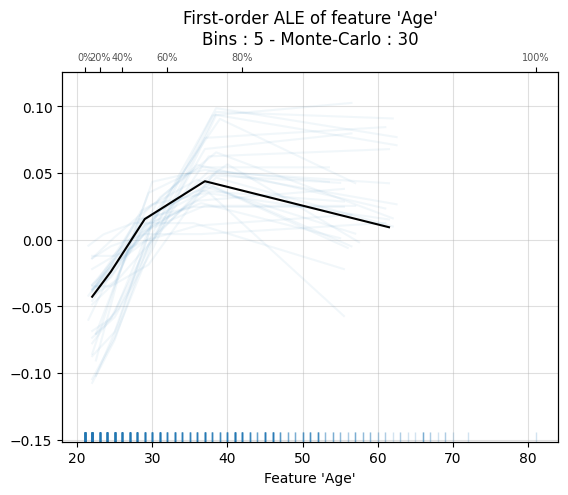

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Age'">

In [17]:
ale_plot(
    model,
    X_train,
    "Age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

**Explanation**

Above the ALE plot for Age shows a non-monotonic, and centered effect on the predicted risk of diabetes. The effect is initially negative for younger ages below around 28 (young age reduces the predicted risk below the average). Then it quickly rises and crosses the zero line around age 29, marking this as the threshold where age starts contributing positively to the risk. The effect peaks between ages 34 and 37, suggesting that the model is most sensitive to increasing age within this range.

Beyond the age of 38, the accumulated effect starts a steady decline (it's still positive across the remaining range). This declining trend contrasts with the PDP plot as the PDP plot showed the partial dependence reaching a high plateau for older individuals. The decrease in the ALE plot suggests that while older age still increases risk compared to the average, the marginal impact of getting even older (from around 40 to 60) is less significant than the impact of aging from 30 to 40. This is likely because other factors like glucose, BMI, etc. become the larger risk factors later in life.

## **ICE Plots**

The code in this section was taken from the local_explanations.ipynb from the class Github.

https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb

**Glucose ICE Plot**

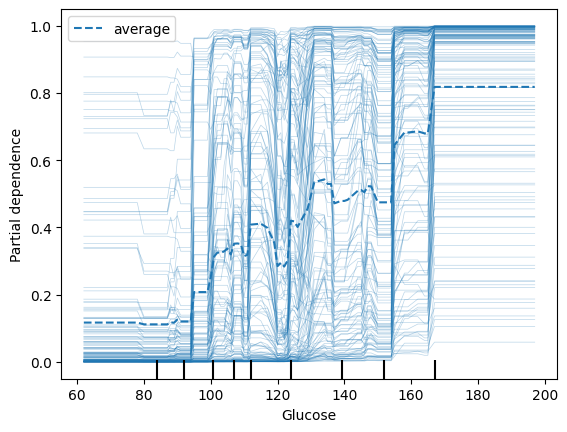

In [18]:
# Use PartialDependenceDisplay to display the ICE plot and the PDP overlayed on top

# Choose the feature of interest
features = ["Glucose"]

PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both') #kind='both'

**Explanation & Analysis of Plots**

The plot above shows the ICE and PDP results for glucose. The dashed line (PDP) shows a clear upward trend where as glucose levels increase, the predicted probability of diabetes quickly rises. At lower glucose values (below  around 100), the model predicts a relatively low risk. However, the probability increases quickly from 120 to 160. The predicted risk stays high after 160. The ICE curves show that this upward effect is consistent across most patients, though the slope of the increase varies slightly by case. The rug plot confirms that most samples fall between 90 and 160, so the most reliable effect is observed in that range.

**BMI ICE Plot**

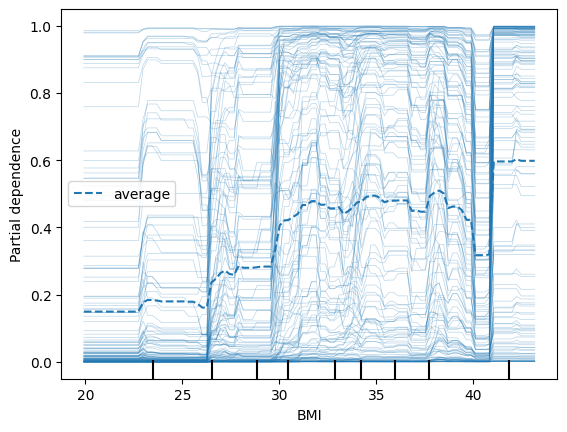

In [19]:
# Use PartialDependenceDisplay to display the ICE plot and the PDP overlayed on top

# Choose the feature of interest
features = ["BMI"]

PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both') #kind='both'

**Explanation & Analysis of Plots**

The model predicts relatively low probabilities of diabetes for BMI values below around 25, after which the predicted risk steadily increases up to around 35. Beyond 35, the average effect levels off with only slight further increases. The rug plot on the x-axis shows that most data points fall between BMI 25 to 40, so the model’s behavior there is more reliable than at other ranges. Overall, the plot suggests that higher BMI is associated with increased diabetes risk, with the strongest changes occurring between BMI 25 to 35.

**Age ICE Plot**

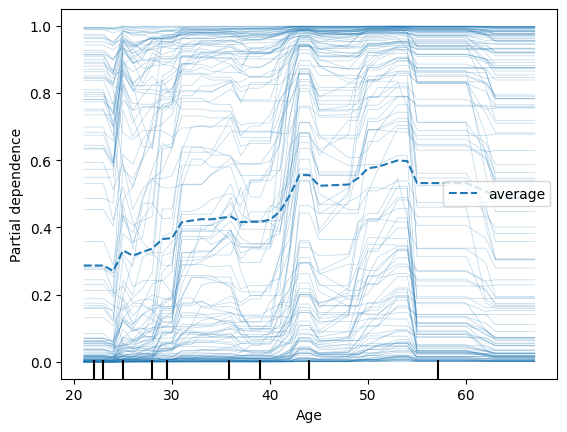

In [20]:
# Use PartialDependenceDisplay to display the ICE plot and the PDP overlayed on top

# Choose the feature of interest
features = ["Age"]

PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both') #kind='both'

**Explanation & Analysis of Plots**

The model generally predicts lower probabilities for younger individuals, with probabilities increasing steadily from around 30 to 50, before leveling off or slightly decreasing at older ages. The marks along the x-axis indicate that most data points lie between ages 25 and 55. This makes the model’s behavior in this range more reliable than at other ranges. Overall, the plot suggests that middle-aged individuals (30 to 50) have the strongest positive influence on the predicted outcome.

## **Summary/Conclusion**

The analysis shows that glucose, BMI, and age are the most influential features for predicting diabetes (in alignment with established medical knowledge). The correlation matrix confirmed strong relationships between glucose and the diabetes (and moderate correlations with BMI and age). PDP and ICE plots highlighted the general upward trends in diabetes risk with higher glucose, BMI, and age, while still showing variation across patients. In contrast to PDP, ALE plots provided smoother and less biased estimates of feature effects. All together, these methods highlight the importance of combining multiple interpretability techniques to gain a better understanding of model behavior and confirm whether predictions are consistent with real-world findings.